In [1]:
import chess
import chess.engine
import random
import numpy

def random_board(max_depth=200):
    board = chess.Board()
    depth = random.randrange(0, max_depth)

    for _ in range(depth):
        allMoves = list(board.legal_moves)
        randomMove = random.choice(allMoves)
        board.push(randomMove)
        if board.is_game_over():
            break

    return board

def stockfight(board, depth):
    with chess.engine.SimpleEngine.popen_uci("C:/DevStuff/stockfish/stockfish-windows-x86-64-avx2.exe") as sf:
        result = sf.analyse(board, chess.engine.Limit(depth=depth))
        score = result["score"].white().score()
        return score

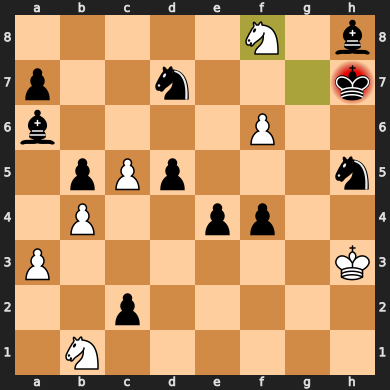

In [2]:
board = random_board()
board


In [3]:
print(stockfight(board, 10))

-864


In [5]:
squaresIndex = {
    'a': 0,
    'b': 1,
    'c': 2,
    'd': 3,
    'e': 4,
    'f': 5,
    'g': 6,
    'h': 7
}

def squareToIndex(square):
    letter = chess.square_name(square)
    return 8 - int(letter[1]), squaresIndex[letter[0]]

def splitDims(board):
    board3d = numpy.zeros((14, 8, 8), dtype=numpy.int8)

    for piece in chess.PIECE_TYPES:
        for square in board.pieces(piece, chess.WHITE):
            idx = numpy.unravel_index(square, (8, 8))
            board3d[piece - 1][7 - idx[0]][idx[1]] = 1
        for square in board.pieces(piece, chess.BLACK):
            idx = numpy.unravel_index(square, (8, 8))
            board3d[piece + 5][7 - idx[0]][idx[1]] = 1

    aux = board.turn
    board.turn = chess.WHITE
    for move in board.legal_moves:
        i, j = squareToIndex(move.to_square)
        board3d[12][i][j] = 1
    board.turn = chess.BLACK
    for move in board.legal_moves:
        i, j = squareToIndex(move.to_square)
        board3d[13][i][j] = 1
    board.turn = aux

    return board3d

# This returns a 3D matrix representation of the board. For example, the first matrix returned is going to be a matrix representation of all the white pawns in the game.
# In the part above we can get a visual representation of the board, so we can see how the pieces are placed.
# The array given by this is going to be the input to the neural network.
# White pieces are first 7, then the black pieces are the last 7.
# Last 2 are all the areas affected by the white, and black pieces.

In [6]:
splitDims(board)

array([[[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        

In [7]:
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.utils as utils

def build_model(conv_size, conv_depth):
    board3d = layers.Input(shape=(14, 8, 8))

    x = board3d
    for _ in range(conv_depth):
        x = layers.Conv2D(conv_size, (3, 3), padding="same", activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, "relu")(x)
    x = layers.Dense(1, 'sigmoid')(x)

    return models.Model(inputs=board3d, outputs=x)

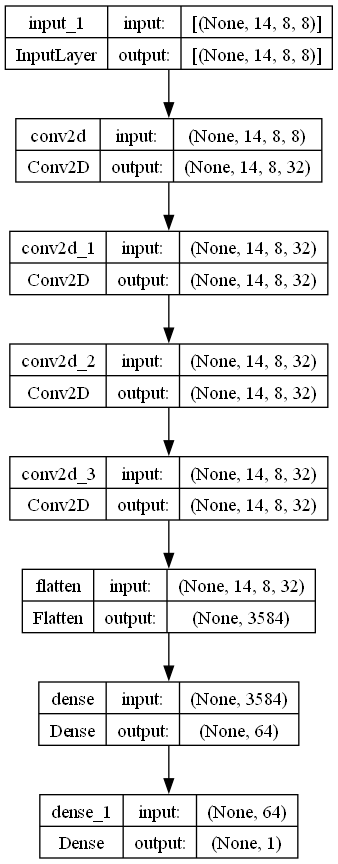

In [8]:
model = build_model(32, 4)
utils.plot_model(model, "model.png", show_shapes=True, show_layer_names=True)

In [9]:
import tensorflow.keras.callbacks as callbacks

def getDataset():
    container = numpy.load("dataset.npz")
    b, v = container["b"], container["v"]
    v = numpy.asarray(v / abs(v).max() / 2 + 0.5, dtype=numpy.float32) # Normalization
    return b, v

x_train, y_train = getDataset()
print(x_train.shape, y_train.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'dataset.npz'